## Исследование влияния learning rate на качество прогнозирования моделей RNN и LSTM

### Подключение библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Input
from tensorflow.keras.optimizers import Adam

import sys
import os
sys.path.append(os.path.abspath('..'))
from helpful_functions import train_val_test_split, \
                              create_sequences,\
                              denormalize

## 1. Загрузка данных

In [4]:
file_path = '../dataset/preprocessed_data.csv'
df = pd.read_csv(file_path)

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

target_feature = 'Global_active_power'
window_size = 60
n_steps_ahead = 10
test_ratio = 0.10
val_ratio = 0.10

train_data, val_data, test_data = train_val_test_split(df, val_ratio, test_ratio)

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

target_idx = df.columns.get_loc(target_feature)

X_train, y_train = create_sequences(train_scaled, target_idx, window_size)
X_val, y_val = create_sequences(val_scaled, target_idx, window_size)
X_test, y_test = create_sequences(test_scaled, target_idx, window_size)

features_count = train_data.shape[1]

## 2. Обучение моделей

In [5]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
results = []

for lr in learning_rates:
    print(f"\nОбучение RNN с learning_rate = {lr}")
    rnn_model = Sequential([
        Input(shape=(window_size, features_count)),
        SimpleRNN(50, activation='tanh'),
        Dense(1)
    ])
    rnn_model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    history_rnn = rnn_model.fit(X_train, y_train,
                                 epochs=5,
                                 batch_size=256,
                                 validation_data=(X_val, y_val))
    
    y_pred_rnn = rnn_model.predict(X_val, verbose=0)
    y_pred_rnn_dn = denormalize(scaler, y_pred_rnn, target_feature, df.columns)
    y_true_val_dn = denormalize(scaler, y_val.reshape(-1, 1), target_feature, df.columns)

    mse_rnn = mean_squared_error(y_true_val_dn, y_pred_rnn_dn)

    results.append({
        'model_type': 'RNN',
        'learning_rate': lr,
        'train_loss': history_rnn.history['loss'][-1],
        'val_loss': history_rnn.history['val_loss'][-1],
        'mse_dn': mse_rnn
    })

for lr in learning_rates:
    print(f"\nОбучение LSTM с learning_rate = {lr}")
    lstm_model = Sequential([
        Input(shape=(window_size, features_count)),
        LSTM(50, activation='tanh'),
        Dense(1)
    ])
    lstm_model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    history_lstm = lstm_model.fit(X_train, y_train,
                                   epochs=5,
                                   batch_size=256,
                                   validation_data=(X_val, y_val))
    
    y_pred_lstm = lstm_model.predict(X_val, verbose=0)
    y_pred_lstm_dn = denormalize(scaler, y_pred_lstm, target_feature, df.columns)
    y_true_val_dn = denormalize(scaler, y_val.reshape(-1, 1), target_feature, df.columns)

    mse_lstm = mean_squared_error(y_true_val_dn, y_pred_lstm_dn)

    results.append({
        'model_type': 'LSTM',
        'learning_rate': lr,
        'train_loss': history_lstm.history['loss'][-1],
        'val_loss': history_lstm.history['val_loss'][-1],
        'mse_dn': mse_lstm
    })


Обучение RNN с learning_rate = 0.1
Epoch 1/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - loss: 0.4756 - val_loss: 0.0353
Epoch 2/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - loss: 0.0289 - val_loss: 0.0162
Epoch 3/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 0.0294 - val_loss: 0.0135
Epoch 4/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - loss: 0.0294 - val_loss: 0.0082
Epoch 5/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 0.0295 - val_loss: 0.0083

Обучение RNN с learning_rate = 0.01
Epoch 1/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - loss: 0.0027 - val_loss: 4.3209e-04
Epoch 2/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 0.0011 - val_loss: 7.1374e-04
Epoch 3/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - loss: 7.5053e-04 - val_loss: 0.0013
Epoch 4/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - loss: 9.2492e-04 - val_loss: 4.8079e-04
Epoch 5/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - loss: 9.0267e-04 - val_loss: 8.5544e-04

Обучение RNN с lea

## 3. Сравнение результатов

In [6]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by=['mse_dn']))

  model_type  learning_rate  train_loss  val_loss    mse_dn
5       LSTM         0.0100    0.000457  0.000341  0.041592
6       LSTM         0.0010    0.000494  0.000360  0.043983
2        RNN         0.0010    0.000528  0.000375  0.045736
7       LSTM         0.0001    0.000536  0.000376  0.045889
3        RNN         0.0001    0.000553  0.000408  0.049829
1        RNN         0.0100    0.000904  0.000855  0.104376
4       LSTM         0.1000    0.000853  0.000872  0.106380
0        RNN         0.1000    0.029181  0.008296  1.012224


## 4. Построение графиков

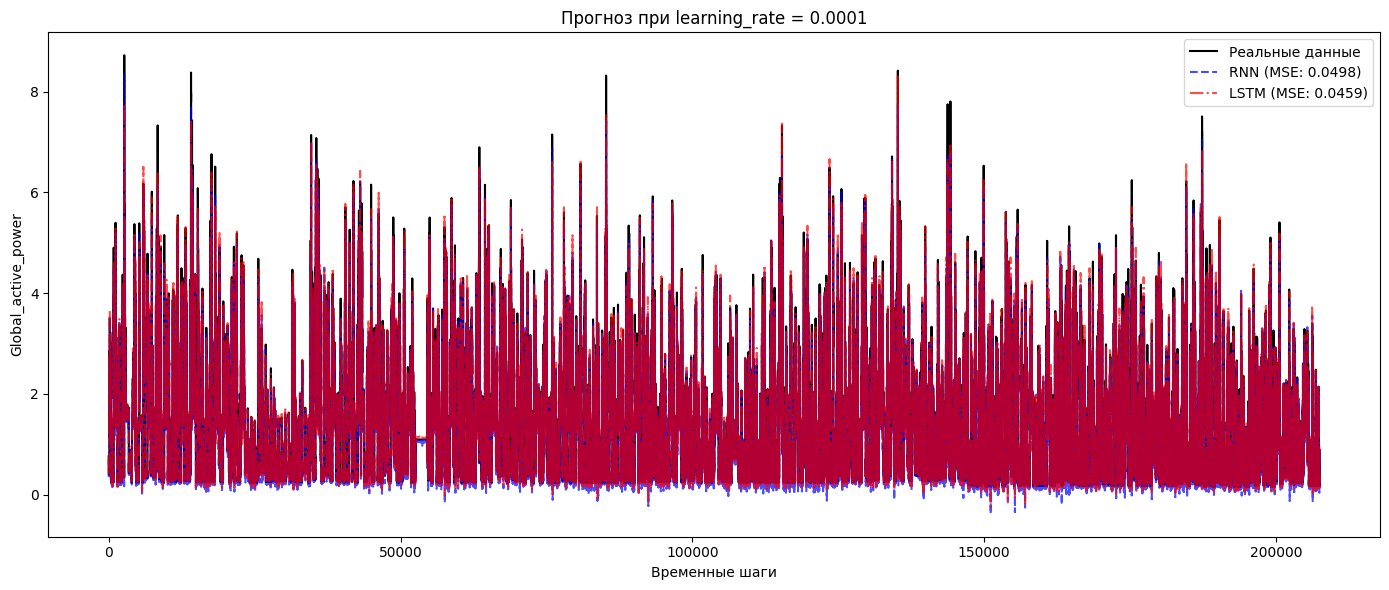

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(y_true_val_dn, label='Реальные данные', color='black')
plt.plot(y_pred_rnn_dn, label=f'RNN (MSE: {mse_rnn:.4f})', linestyle='--', color='blue', alpha=0.7)
plt.plot(y_pred_lstm_dn, label=f'LSTM (MSE: {mse_lstm:.4f})', linestyle='-.', color='red', alpha=0.7)
plt.title(f'Прогноз при learning_rate = {lr}')
plt.xlabel('Временные шаги')
plt.ylabel('Global_active_power')
plt.legend()
plt.tight_layout()
plt.show()